In [1]:
from bigbang.archive import Archive
import matplotlib.pyplot as plt
import pandas as pd
import re

/home/sb/projects/bigbang-multi/bigbang/config/config.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dictionary = yaml.load(stream)


## Preparing the data

Open a mailing list archive.

In [30]:
arx = Archive("httpbisa",mbox=True)

/home/sb/projects/bigbang-multi/bigbang/bigbang/mailman.py:179: UserWarning: No mailing list name found at httpbisa
  warnings.warn("No mailing list name found at %s" % url)


We will need to extract email addresses and email domains from the `From` field of the emails.

In [31]:
email_regex = r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+'
domain_regex = r'[@]([a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)$'

email = re.search(email_regex, "Gerald Oskoboiny <gerald@w3.org>")[0]
re.search(domain_regex, email)[1]

'w3.org'

In [32]:
def extract_email(from_field):
    match = re.search(email_regex, from_field)
    
    if match is not None:
        return match[0]
    
    else:
        return None

In [33]:
def extract_domain(from_field):
    match = re.search(email_regex, from_field)
    
    if match is not None:
        return re.search(domain_regex, match[0])[1]
    
    else:
        return None

We can break down all the emails sent to the mailing list by domain.

In [34]:
arx.data['From'].apply(extract_domain).value_counts().head(15)

gmail.com              6527
mnot.net               4117
gmx.de                 3606
1wt.eu                 1410
phk.freebsd.dk         1193
treenet.co.nz          1006
qbik.com                843
henriknordstrom.net     790
google.com              732
chromium.org            700
gbiv.com                697
microsoft.com           641
ietf.org                629
intalio.com             420
apple.com               391
Name: From, dtype: int64

We can see that there are some generic email domains (gmail.com), some personal email domains (mnot.net), and some corporate email domains (google.com, apple.com). If we are interested in organizations, we need to identify domains that represent collections of people representing a single organization. How can we find that out?

## Defining Domain Entropy

In [35]:
emails = arx.data['From'].apply(extract_email)
domains = arx.data['From'].apply(extract_domain)
froms = pd.concat([arx.data['From'], emails, domains], axis=1, keys=['From','email','domain'])

In [39]:
froms.head(10)

,From,email,domain
Message-ID,,,
<20020412162821.GA21015@w3.org>,Gerald Oskoboiny <gerald@w3.org>,gerald@w3.org,w3.org
<009901c1e5b5$07513b90$71432099@larrypad>,"""Larry Masinter"" <LMM@acm.org>",LMM@acm.org,acm.org
<20020423124259.Y20848@www.markbaker.ca>,Mark Baker <distobj@acm.org>,distobj@acm.org,acm.org
<82ofg99bld.fsf@dhcp74.ma.virata.com>,Scott Lawrence <lawrence@world.std.com>,lawrence@world.std.com,world.std.com
<62E4D97E-57BF-11D6-87D7-000393753936@apache.org>,"""Roy T. Fielding"" <fielding@apache.org>",fielding@apache.org,apache.org
<79107D208BA38C45A4E45F62673A434D07371BCD@red-msg-07.redmond.corp.microsoft.com>,"""Henrik Frystyk Nielsen"" <henrikn@microsoft.com>",henrikn@microsoft.com,microsoft.com
<002001c1ebe3$98411470$77432099@larrypad>,"""Larry Masinter"" <LMM@acm.org>",LMM@acm.org,acm.org
<F71FB682-57E1-11D6-87D7-000393753936@apache.org>,"""Roy T. Fielding"" <fielding@apache.org>",fielding@apache.org,apache.org
<20020424213946.D20848@www.markbaker.ca>,Mark Baker <distobj@acm.org>,distobj@acm.org,acm.org


In order to evaluate the extent to which a domain represents (a) and individual, (b) a set of organized individuals, or (c) a large set of unorganized individuals, we will measure the concentration of the distribution of email addresses per domain.

If $n_D$ is the number of messages from domain $D$, and $n_e$ is the number of messages from email address $e$, then we will compute the information entropy of the frequency of $e$ in $D$.

$$H(D) = - \sum_{e \in D} \frac{n_e}{n_D} \log \frac{n_e}{n_D}$$

In [8]:
import math

def domain_entropy(domain):
    domain_messages = froms[froms['domain'] == domain]
    
    n_D = domain_messages.shape[0]
    
    entropy = 0
    
    emails = domain_messages['email'].unique()
    
    for em in emails:
        em_messages = domain_messages[domain_messages['email'] == em]
        n_e = em_messages.shape[0]
        
        p_em = float(n_e) / n_D
        
        entropy = entropy - p_em * math.log(p_em)
        
    return entropy

Using metric, we can now see that Mark Nottingham's personal domain `mnot.net` has lower domain entropy than the company Apple's domain `apple.com`, which has lower domain entropy than the generic personal domain `gmail.com`.

In [9]:
domain_entropy('mnot.net')

0.15028185037229927

In [10]:
domain_entropy('apple.com')

1.192743085719121

In [11]:
domain_entropy('gmail.com')

2.9844587681860513

## Using the metric

We can compute the domain entropy for all domains and plot these values.

In [12]:
domains = froms['domain'].unique()

In [13]:
domain_entropies = pd.Series(index= domains, data = [domain_entropy(domain) for domain in domains])
domain_entropies = domain_entropies.sort_values(ascending=False)

Text(0.5, 1.0, 'Within Mailing List Domain Entropy')

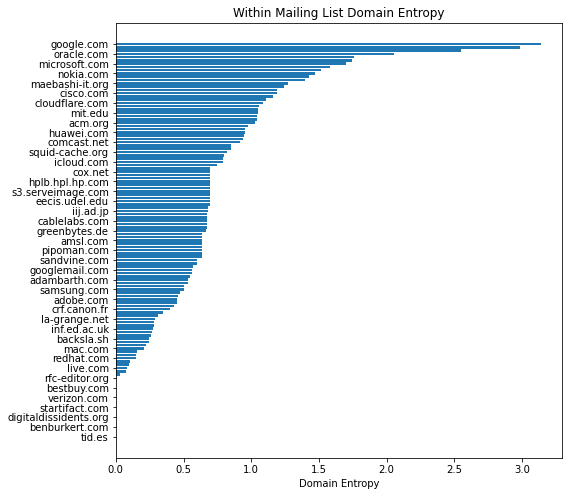

In [15]:
import numpy as np

y_limit = 121
dom_ent = domain_entropies.head(y_limit)

fig, ax = plt.subplots(figsize=(8,8))

domains = dom_ent.index
y_pos = np.arange(len(domains))

ax.barh(
    y_pos,
    dom_ent.values
)

ax.set_yticks(y_pos[::3])
ax.set_yticklabels(domains[::3])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Domain Entropy')
ax.set_title('Within Mailing List Domain Entropy')

The most surprising thing about this metric is that the generic email domain `gmail.com` has less entropy than the corporate domain `google.com`. Why is that?

In [36]:
domain_entropies.head(20)

google.com         3.140787
gmail.com          2.984459
hotmail.com        2.553237
oracle.com         2.058373
w3.org             1.758979
yahoo.com          1.744146
microsoft.com      1.699436
akamai.com         1.585919
ericsson.com       1.512764
nokia.com          1.475076
us.ibm.com         1.430280
opera.com          1.395972
maebashi-it.org    1.273028
fb.com             1.241696
apple.com          1.192743
cisco.com          1.187929
ietf.org           1.159670
chromium.org       1.112767
cloudflare.com     1.088900
csail.mit.edu      1.054920
dtype: float64

It looks like the `gmail.com` domain is dominated by a few major individuals, whereas the `google.com` representation is smaller overall, and more evenly distributed across their team members.

In [37]:
froms[froms['domain'] == 'gmail.com']['email'].value_counts().head(10)

martin.thomson@gmail.com      2021
grmocg@gmail.com               973
jasnell@gmail.com              820
zhong.j.yu@gmail.com           233
kazuhooku@gmail.com            205
bizzbyster@gmail.com           186
tatsuhiro.t@gmail.com          164
hallam@gmail.com               152
potswa@gmail.com               132
lucaspardue.24.7@gmail.com      94
Name: email, dtype: int64

<AxesSubplot:>

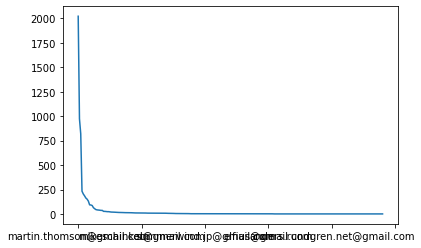

In [26]:
froms[froms['domain'] == 'gmail.com']['email'].value_counts().plot()

In [38]:
froms[froms['domain'] == 'google.com']['email'].value_counts().head(10)

mkwst@google.com       100
rch@google.com          96
wenboz@google.com       57
akalin@google.com       47
estark@google.com       45
yhirano@google.com      45
tyoshino@google.com     41
jyasskin@google.com     40
bemasc@google.com       38
ianswett@google.com     23
Name: email, dtype: int64

<AxesSubplot:>

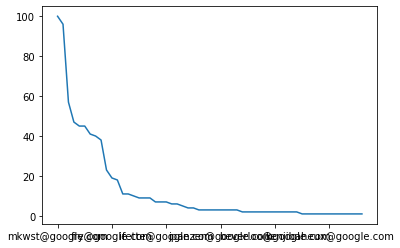

In [27]:
froms[froms['domain'] == 'google.com']['email'].value_counts().plot()